In [1]:
!pip install torchbearer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 kB 6.8 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torchbearer

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import vgg16_bn, vgg19_bn
num_classes = 10
model = vgg16_bn()
model.features = model.features[:-1]
model.avgpool = nn.AvgPool2d(2)
model.classifier = nn.Linear(512, num_classes)

In [4]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
    elif isinstance(m, torch.nn.BatchNorm2d):
        m.weight.data = torch.rand(m.weight.data.shape)
        m.bias.data = torch.zeros_like(m.bias.data)

model = model.apply(init_weights)

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

train_batch_size = 128
test_batch_size = 128

# convert each image to tensor format
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# load data
trainset = CIFAR10(root='.', train=True, download=True, transform=transform_train)
testset = CIFAR10(root='.', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:05<00:00, 29438235.52it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [6]:
from torch.utils.data import DataLoader, random_split

trainloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
# validloader = DataLoader(valid_data, batch_size=train_batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=test_batch_size, shuffle=False)

In [7]:
import random
import numpy as np

sparse_ratio = 0.9

s_inputs = []
s_targets = []

samples = next(iter(DataLoader(trainset, batch_size=300, shuffle=True)))
for t in set(trainset.targets):
    indices = random.sample([i for i, x in enumerate(samples[1]) if x == t], 10)
    s_inputs += [samples[0][i].tolist() for i in indices]
    s_targets += [samples[1][i].tolist() for i in indices]

s_inputs = torch.Tensor(np.array(s_inputs))
s_targets = torch.Tensor(np.array(s_targets)).to(torch.long)

print(s_inputs.shape)
print(s_targets.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100])


In [8]:
import time

model.train()
model.zero_grad()
weights = [weight for name, weight in model.named_parameters() if name.endswith('.weight')]

# feed sample data to the model
outputs = model.forward(s_inputs)
loss = F.cross_entropy(outputs, s_targets).backward()
# grad_w = list(torch.autograd.grad(loss, weights))


In [9]:
scores = {}

for name, weight in model.named_parameters():
    if name.endswith('.weight'):
        scores[name.replace('.weight', '')] = torch.abs(weight.detach() * weight.grad) 

In [10]:
score_vec = torch.cat([torch.flatten(x) for x in scores.values()])
norm_factor = torch.sum(score_vec)
score_vec.div_(norm_factor)

tensor([2.8064e-05, 3.0741e-05, 3.0546e-05,  ..., 7.8161e-09, 2.1668e-07,
        1.8674e-06])

In [11]:
num_prune = np.ceil(len(score_vec) * sparse_ratio).astype(int)
print("Number of params to prune:", num_prune)
print("Remaining params:", score_vec.shape - num_prune)

Number of params to prune: 13247828
Remaining params: [1471980]


In [12]:
num_keep = (score_vec.shape - num_prune)[0]
threshold = torch.topk(score_vec, num_prune, sorted=True)[0][-1]
print(threshold)

tensor(4.2658e-10)


In [13]:
masks = {}
named_modules = dict(model.named_modules())

for m, g in scores.items():
    masks[named_modules[m]] = ((g / norm_factor) <= threshold).float()

In [14]:
print('Masks')
print(torch.sum(torch.cat([torch.flatten(x == 1) for x in masks.values()])))

Masks
tensor(1471981)


In [15]:
from torch.nn.utils import prune

for m in masks.keys():
    m = prune.custom_from_mask(m, name='weight', mask=masks[m])

In [16]:
import matplotlib.pyplot as plt

def plot_loss(train_loss, test_loss):
    plt.plot(train_loss, label="Training data")
    plt.plot(test_loss, label="Validation data")
    plt.xlabel("Epochs", fontsize="18")
    plt.ylabel("Loss", fontsize="18")
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(fontsize="15")
    plt.grid()
    plt.show();

def plot_acc(train_acc, test_acc):
    plt.plot(train_acc, label="Training data")
    plt.plot(test_acc, label="Validation data")
    plt.xlabel("Epochs", fontsize="18")
    plt.ylabel("Accuracy", fontsize="18")
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(fontsize="15")
    plt.grid();

In [17]:
from torchbearer import Trial

In [18]:
from torchbearer import Callback
from torchbearer import callbacks
from torchbearer.callbacks import MultiStepLR

@callbacks.on_end_epoch
def callback(state):
    try:
        train_loss[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['loss']
        train_acc[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['acc']
        test_loss[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['val_loss']
        test_acc[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['val_acc']
    except:
        pass

In [19]:
def train_model(model, epochs=80):
    model = model.to(device)
    loss_function = nn.CrossEntropyLoss()
    scheduler = callbacks.MultiStepLR(milestones=[40, 60], gamma=0.1)
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], callbacks=[callback, scheduler]).to(device)
    trial.with_generators(trainloader, test_generator=testloader, val_generator=testloader)
    trial.run(epochs)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)

In [20]:
from torch import optim


num_epochs = 80

train_loss = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)
test_loss = np.zeros(num_epochs)
test_acc = np.zeros(num_epochs)

train_model(model, epochs=num_epochs)

0/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://githu

0/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

1/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

1/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

2/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

2/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

3/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

3/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

4/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

4/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

5/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

5/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

6/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

6/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

7/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

7/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

8/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

8/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

9/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

9/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

10/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

10/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

11/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

11/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

12/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

12/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

13/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

13/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

14/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

14/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

15/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

15/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

16/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

16/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

17/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

17/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

18/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

18/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

19/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

19/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

20/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

20/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

21/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

21/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

22/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

22/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

23/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

23/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

24/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

24/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

25/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

25/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

26/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

26/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

27/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

27/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

28/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

28/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

29/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

29/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

30/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

30/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

31/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

31/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

32/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

32/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

33/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

33/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

34/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

34/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

35/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

35/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

36/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

36/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

37/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

37/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

38/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

38/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

39/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

39/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

40/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

40/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

41/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

41/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

42/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

42/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

43/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

43/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

44/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

44/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

45/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

45/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

46/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

46/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

47/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

47/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

48/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

48/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

49/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

49/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

50/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

50/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

51/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

51/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

52/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

52/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

53/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

53/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

54/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

54/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

55/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

55/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

56/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

56/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

57/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

57/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

58/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

58/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

59/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

59/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

60/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

60/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

61/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

61/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

62/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

62/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

63/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

63/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

64/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

64/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

65/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

65/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

66/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

66/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

67/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

67/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

68/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

68/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

69/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

69/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

70/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

70/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

71/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

71/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

72/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

72/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

73/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

73/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

74/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

74/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

75/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

75/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

76/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

76/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

77/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

77/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

78/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

78/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

79/80(t):   0%|          | 0/391 [00:00<?, ?it/s]

79/80(v):   0%|          | 0/79 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/79 [00:00<?, ?it/s]

{'test_loss': 2.30258846282959, 'test_acc': 0.09999999403953552}


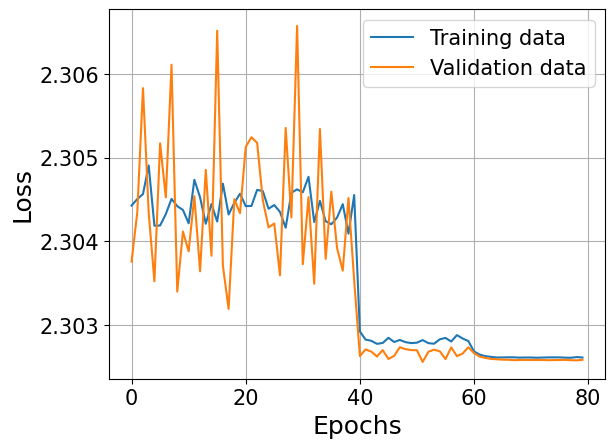

In [21]:
plot_loss(train_loss, test_loss)

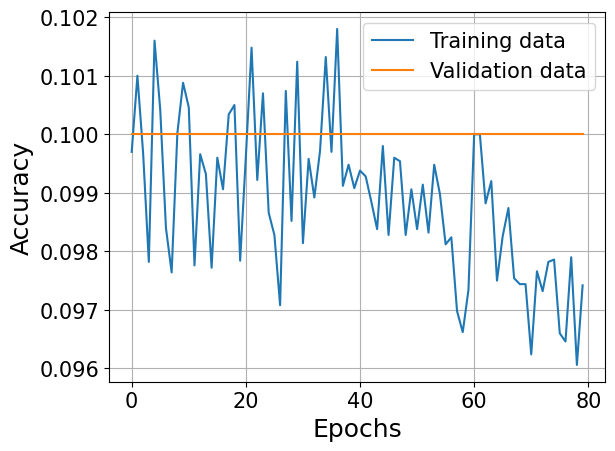

In [22]:
plot_acc(train_acc, test_acc)

In [23]:
#save the trained model weights
torch.save(model.state_dict(), "./vgg16-90-inversion.weights")
# from google.colab import files
# files.download('vgg19-90-2.weights')